<a href="https://colab.research.google.com/github/cherryng/MLcourse/blob/main/H4_Q3_NLP_for_ClinicalData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to the Mothers and Machine Learning Course, Week 4!




This is an optional Python tutorial that was proposed in the ‘AI for Clinician Champions Certificate' program! https://michener.ca/ce_course/ai-for-clinician-champions-certificate-program/
- 

This program is offered by Michener Institute & Vector Institute for clinicians who wish to learn more about AI in Healthcare.

Assignment Developer: Flora Wan.

***Never stop learning!***


This week's case study will introduce you to NLP (Natural Language Processing).  The goal of this case study is to parse a set of medical report notes, or SOAP notes, in order to create a classification model to predict the patient's diagnosis.

The dataset was originally found here: https://data.world/arvin6/medical-records-10-yrs (link might not be working but data can be still loaded below in the code).

**Important Note:** Before running the code below, make sure to change the runtime type to "GPU".  To do this, go to the Runtime menu > Change runtime type.  In the Hardware accelerator drop-down, select "GPU" and then "Save".  Google Colab will prompt you to restart the runtime.  The reason why we have to change the runtime to "GPU" is to speed up the processing speed of the neural network that will be used to train our model.
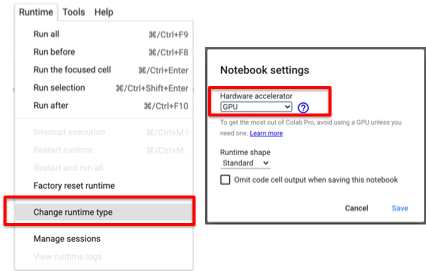


In [ ]:
# Import Python packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf

*Useful tip*: The packages imported above are frequently-used Python packages for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (sklearn, tensorflow).  

# Import dataset

First, we connect to Google Drive and import the two relevant data files in CSV (comma-separated values) format.

## Download the dataset


In [ ]:
from IPython.display import clear_output
import zipfile
from pathlib import Path

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/file/d/1GThRqLRy1Dl55pIM6RESTX51yXjnvSFE/view?usp=sharing' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GThRqLRy1Dl55pIM6RESTX51yXjnvSFE" -O 'arvin6-medical-records-10-yrs.zip' && rm -rf /tmp/cookies.txt

with zipfile.ZipFile('arvin6-medical-records-10-yrs.zip', 'r') as zip_ref:
    zip_ref.extractall('Assignment 4')

# The dataset is stored on Google drive as a zip file. When we run the cell
# Colab will retrieve this zip file and unzip it into your Google Colab environment.

# You can have a look at the dataset structure by pressing the folder icon on the left sidebar.

dataset_folder = Path("/content/Assignment 4/arvin6-medical-records-10-yrs") 

# Your output should contain **encounter.csv** and **encounter_dx.csv**:
print(list(dataset_folder.glob("*.*")))

--2022-03-31 00:39:56--  https://docs.google.com/uc?export=download&confirm=&id=1GThRqLRy1Dl55pIM6RESTX51yXjnvSFE
Resolving docs.google.com (docs.google.com)... 74.125.204.100, 74.125.204.138, 74.125.204.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.204.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-2g-docs.googleusercontent.com/docs/securesc/185qmv6utf466qi9plq01c64chu1etkf/jei9cbg159vp68t1av0kppasql16v37b/1648687125000/14757718682151807649/02630897643285806874Z/1GThRqLRy1Dl55pIM6RESTX51yXjnvSFE?e=download [following]
--2022-03-31 00:39:58--  https://doc-10-2g-docs.googleusercontent.com/docs/securesc/185qmv6utf466qi9plq01c64chu1etkf/jei9cbg159vp68t1av0kppasql16v37b/1648687125000/14757718682151807649/02630897643285806874Z/1GThRqLRy1Dl55pIM6RESTX51yXjnvSFE?e=download
Resolving doc-10-2g-docs.googleusercontent.com (doc-10-2g-docs.googleusercontent.com)... 74.125.23.132, 2404:6800:4008:c02::84
Connecting to doc-10-2g

In [ ]:
# Transform the datasets into a Pandas dataframe object
encounter_csv = dataset_folder / "encounter.csv"
encounter_dx_csv = dataset_folder / "encounter_dx.csv"
df_encounter = pd.read_csv(encounter_csv)
df_encounter_dx = pd.read_csv(encounter_dx_csv)

## Load data from CSV files

The two CSV files loaded are:

- encounter.csv:  This table contains records representing each patient's encounter with the healthcare system.  This includes clinic assessments, pharmacy visits, and lab orders.  We will focus specifically on the "SOAP_Note" column.

- encounter_dx.csv:  This table contains the corresponding diagnosis for encounters involving a clinial assessment.  From this table, we will focus on the "description" column which is the patient diagnosis that we will try to predict.

In [ ]:
# Print the number of records in the df_encounter dataframe
print(f"Number of records: {len(df_encounter)}")

Number of records: 5447


In [ ]:
# Recall that df_encounter contains the encounter.csv: 
# This table contains records representing each patient's encounter with the healthcare system. 
# This includes clinic assessments, pharmacy visits, and lab orders. We will focus specifically on the "SOAP_Note" column.

# Look at the first 5 rows in the dataframe using the head() method
df_encounter.head()

,Provider_Org,Encounter_ID,Member_ID,Provider_ID,Provider_NPI,Clinic_ID,Encounter_DateTime,Encounter_Description,CC,Episode_ID,...,medication_orders_count,medication_fulfillment_count,vital_sign_count,therapy_orders_count,therapy_actions_count,immunization_count,Has_Appt,SOAP_Note,consult_ordered,Disposition
0,ExactData Medical Health System,L8694502508698944760,568001602-01,663746638,2531462832,Sidney Hillman Health Center,2005-06-30T19:15:00Z,Lacy visited primary care physician on 6/30/20...,mild occasional lightheadedness,L8694502508698944760,...,1,0,7,0,1,0,True,s:a 33 year old female crystallographer presen...,NaN,ReleasedWithoutLimitations
1,ExactData Medical Health System,V3046573432409333612,568001602-01,523808810,1380097962,Corner Drug Store,2005-07-01T23:44:00Z,Lacy visited pharmacy on 7/1/2005 6:44:00 PM f...,NaN,L8694502508698944760,...,0,1,0,0,0,0,False,NaN,NaN,ReleasedWithoutLimitations
2,ExactData Medical Health System,X3228783097331248888,568001602-01,695700114,1261075194,Wood Diagnostic Labs,2005-07-05T14:54:00Z,Lacy visited medical lab on 7/5/2005 9:54:00 A...,NaN,L8694502508698944760,...,0,0,0,0,0,0,False,NaN,NaN,ReleasedWithoutLimitations
3,ExactData Medical Health System,M3204724885018391695,568001602-01,663746638,2531462832,Sidney Hillman Health Center,2005-10-07T15:45:00Z,Lacy visited primary care physician on 10/7/20...,NaN,M3204724885018391695,...,0,0,7,0,1,1,True,s:33 yr old female crystallographer presents t...,NaN,ReleasedWithoutLimitations
4,ExactData Medical Health System,G7012345417035113309,568001602-01,695700114,1261075194,Wood Diagnostic Labs,2005-10-12T20:33:00Z,Lacy visited medical lab on 10/12/2005 3:33:00...,NaN,M3204724885018391695,...,0,0,0,0,0,0,False,NaN,NaN,ReleasedWithoutLimitations


In [ ]:
# Print the number of records in the df_encounter_dx dataframe
print(f"Number of records: {len(df_encounter_dx)}")


Number of records: 3063


In [ ]:
# Recall that df_encounter_dx contains the encounter_dx.csv: 
# This table contains the corresponding diagnosis for encounters involving a clinial assessment. 
# From this table, we will focus on the "description" column which is the patient diagnosis that we will try to predict.

# Look at the first 5 rows in the dataframe using the head() method
df_encounter_dx.head()

,Provider_Org,code,vocab,description,severity,Encounter_ID
0,ExactData Medical Health System,401.9,ICD9,Hypertension,mild,L8694502508698944760
1,ExactData Medical Health System,V70.0,ICD9,General medical examination,NaN,M3204724885018391695
2,ExactData Medical Health System,496,ICD9,Chronic Obstructive Pulmonary Disease,critical,C2819614934032019919
3,ExactData Medical Health System,401.9,ICD9,Hypertension,mild,S4571692645992867370
4,ExactData Medical Health System,V70.0,ICD9,General medical examination,NaN,J6262874375300991101


# Select features

Currently, the information we need is in two separate dataframes.  In order to combine the information into a single dataframe, we will use the Pandas Python package to merge the tables and then select the relevant rows and columns.

*Useful tip*: "Pandas" (which stands for Python Data Analysis) is a flexible Python package to manipulate and organize data.  You will often see Pandas represented as the short form "pd".

## Merge tables

Use the *merge* method in Pandas to combine the df_encounter and df_encounter_dx dataframes.  The "on" parameter specifies the *key* to match the records in each dataframe to each other.  In this case, we will be using the "Encounter_ID" as the key to connect the records in the two dataframes.

*Useful tip*: Electronic medical records are generally stored in a "relational database" format, where tables representing specific objects are linked together using unique keys.  To learn more about how to extract data from a relational database, look up "SQL", which stands for Structured Query Language.

In [ ]:
# Merge the df_encounter and df_encounter_dx dataframes
df_merged = pd.merge(df_encounter, df_encounter_dx, on="Encounter_ID")
df_merged.head()

,Provider_Org_x,Encounter_ID,Member_ID,Provider_ID,Provider_NPI,Clinic_ID,Encounter_DateTime,Encounter_Description,CC,Episode_ID,...,immunization_count,Has_Appt,SOAP_Note,consult_ordered,Disposition,Provider_Org_y,code,vocab,description,severity
0,ExactData Medical Health System,L8694502508698944760,568001602-01,663746638,2531462832,Sidney Hillman Health Center,2005-06-30T19:15:00Z,Lacy visited primary care physician on 6/30/20...,mild occasional lightheadedness,L8694502508698944760,...,0,True,s:a 33 year old female crystallographer presen...,NaN,ReleasedWithoutLimitations,ExactData Medical Health System,401.9,ICD9,Hypertension,mild
1,ExactData Medical Health System,M3204724885018391695,568001602-01,663746638,2531462832,Sidney Hillman Health Center,2005-10-07T15:45:00Z,Lacy visited primary care physician on 10/7/20...,NaN,M3204724885018391695,...,1,True,s:33 yr old female crystallographer presents t...,NaN,ReleasedWithoutLimitations,ExactData Medical Health System,V70.0,ICD9,General medical examination,NaN
2,ExactData Medical Health System,C2819614934032019919,937650000-01,581395544,2463742680,Family Health,2005-03-12T04:07:00Z,Alexa visited emergency clinic on 3/11/2005 11...,critical dyspnea,C2819614934032019919,...,0,True,s:a 32 year old f presents with critical dyspn...,NaN,ReleasedWithoutLimitations,ExactData Medical Health System,496,ICD9,Chronic Obstructive Pulmonary Disease,critical
3,ExactData Medical Health System,S4571692645992867370,937650000-01,135055397,1032122911,Advocate Medical Group,2005-04-19T15:00:00Z,Alexa visited primary care physician on 4/19/2...,mild spells of vertigo,S4571692645992867370,...,0,True,s:a white female aged 32 Ys presents with 8 mo...,NaN,ReleasedWithoutLimitations,ExactData Medical Health System,401.9,ICD9,Hypertension,mild
4,ExactData Medical Health System,J6262874375300991101,937650000-01,135055397,1032122911,Advocate Medical Group,2005-10-20T18:30:00Z,Alexa visited primary care physician on 10/20/...,NaN,J6262874375300991101,...,1,True,s:32 yr old white F presents today for routine...,NaN,ReleasedWithoutLimitations,ExactData Medical Health System,V70.0,ICD9,General medical examination,NaN


In [ ]:
# Look at the available columns
df_merged.columns

Index(['Provider_Org_x', 'Encounter_ID', 'Member_ID', 'Provider_ID',
       'Provider_NPI', 'Clinic_ID', 'Encounter_DateTime',
       'Encounter_Description', 'CC', 'Episode_ID', 'Patient_DOB',
       'Patient_Gender', 'Facility_Name', 'Provider_Name', 'Specialty',
       'Clinic_Type', 'lab_orders_count', 'lab_results_count',
       'medication_orders_count', 'medication_fulfillment_count',
       'vital_sign_count', 'therapy_orders_count', 'therapy_actions_count',
       'immunization_count', 'Has_Appt', 'SOAP_Note', 'consult_ordered',
       'Disposition', 'Provider_Org_y', 'code', 'vocab', 'description',
       'severity'],
      dtype='object')

## Select relevant rows and columns

Since we are only interested in the SOAP notes (input) and diagnosis description (output), we will select those two columns from the dataframe. In addition, we will also need to do some data cleaning to make sure that we're not passing any missing data into the machine learning model.

In [ ]:
# Select the relevant columns for the NLP case study. We will noly be using 2 of the columns in the new merged dataset.
df_merged = df_merged[['SOAP_Note', 'description']]

In [ ]:
# Print the number of records in this dataframe
print(f"Number of records: {len(df_merged)}")

Number of records: 3059


In [ ]:
df_merged.head(10)

,SOAP_Note,description
0,s:a 33 year old female crystallographer presen...,Hypertension
1,s:33 yr old female crystallographer presents t...,General medical examination
2,s:a 32 year old f presents with critical dyspn...,Chronic Obstructive Pulmonary Disease
3,s:a white female aged 32 Ys presents with 8 mo...,Hypertension
4,s:32 yr old white F presents today for routine...,General medical examination
5,s:53 year old female presents today for routin...,General medical examination
6,s:53 year old female presents today for routin...,Chronic Obstructive Pulmonary Disease
7,s:a 53 yr old female with C/O severe fever for...,Chronic Obstructive Pulmonary Disease
8,NaN,Chronic Obstructive Pulmonary Disease
9,s:pt presents with Hemorrhagic Stroke for more...,Hemorrhagic Stroke


In [ ]:
# Look for any missing data
df_merged.isnull().sum()

SOAP_Note      191
description      0
dtype: int64

In [ ]:
# Filter out the records with missing SOAP notes
df_merged = df_merged[df_merged['SOAP_Note'].notnull()]

In [ ]:
# Display the final dataset to be used for training the prediction model
# "SOAP_Note" is our input text, and "description" is our output, or label
print("Number of records in final dataset:", len(df_merged))
df_merged.head()

Number of records in final dataset: 2868


,SOAP_Note,description
0,s:a 33 year old female crystallographer presen...,Hypertension
1,s:33 yr old female crystallographer presents t...,General medical examination
2,s:a 32 year old f presents with critical dyspn...,Chronic Obstructive Pulmonary Disease
3,s:a white female aged 32 Ys presents with 8 mo...,Hypertension
4,s:32 yr old white F presents today for routine...,General medical examination


# Explore dataset

Before training any machine learning model, it's important to first explore and visualize the data.  

## Data values

Let's take a look at what typical SOAP Notes and its corresponding clinical diagnosis look like in this dataset. 

*Useful tip*: The [0] in the code denotes the index of the record.  In the previous section, we noted that there are 2868 records in our dataframe, so you can change the number in the [ ] brackets to any number between 0 and 2867 to look at other examples (Python counts from "0", not "1").  If you change the index value for the soap note, remember to also change it for the description so that you are looking at data from the same record.

In [ ]:
# Print out the SOAP note in the first record of our dataframe 
# You may change the index number to see other Soap Notes
df_merged['SOAP_Note'][0]

's:a 33 year old female crystallographer presents with mild spells of vertigo, mild headaches particularly at the back of the head and in the morning x 2 weeks. pt also reports chronic mild occasional lightheadedness. o:Height 160 cm, Weight 53.8 kg, Temperature 37.3 C, Pulse 76, SystolicBP 146, DiastolicBP 93, Respiration 15, Heart = 2/6 systolic murmur at base of heart, Chest = clear to auscultation B/L, no rales or wheezing, Extremities = no edema or clubbing, Heart = normal S1, S2, RRR a:Hypertension p:performed E/M Level 2 (established patient) - Completed, and prescribed Hydrochlorothiazide - 50 mg po qd, and ordered Cholesterol.'

In [ ]:
# Print the corresponding diagnosis for this clinical assessment
df_merged['description'][0]

'Hypertension'

In [ ]:
# Print out the SOAP note in the first record of our dataframe
df_merged['SOAP_Note'][400]

's:44 year old male with approx. 4 months old amputated R shoulder presents for physical therapy visit. pt reports no issues o:, Strengthening. Sensation to pain and touch intact. a:Disarticulation of right shoulder status p:Continue with weekly sessions as per plan. performed rehabilitation and remedial exercises following disarticulation of right shoulder - right shoulder - patient tolerated treatment well, showed increased ROM and strength.'

In [ ]:
# Print the corresponding diagnosis for this clinical assessment
df_merged['description'][400]

'Disarticulation of right shoulder status'

## Remove words related to target from the input text

You might notice that the diagnosis itself is sometimes mentioned specifically in the note (for example, in the previous example, "Hypertension" is specified after the a: tag).  In order to make sure that we don't have "data leakage" between the input and target, let's remove any words in the input text that matches the actual diagnosis.

*Useful tip*: The NLTK package (Natural Language Toolkit) is a powerful Python package to parse text.

In [ ]:
import nltk

# Function to remove words in the input matching words in the label
# All characters are converted to lower case
def removeLabelWords(input, label):
  input_words = [word.lower() for word in nltk.wordpunct_tokenize(input)]
  label_words = [word.lower() for word in nltk.wordpunct_tokenize(label)]

  result_words  = [word for word in input_words if word not in label_words]
  result = ' '.join(result_words)

  return result

# For each record in the dataframe, parse the input text to remove the diagnosis,
# and store the result in the new column named "SOAP_Note_transformed"
df_merged['SOAP_Note_transformed'] = df_merged.apply(lambda row: removeLabelWords(row['SOAP_Note'], row['description']), axis=1)
  

Confirm that words matching the diagnosis is removed from the input text.

In [ ]:
# Helper function to wrap text to match screen size
import textwrap
def wrap(string, max_width=100):
    return '\n'.join(textwrap.wrap(string, max_width))

# Pick a random record
import random
record_id = random.randint(0, len(df_merged))
print("Record ID:", record_id, "\n")

# Print out the diagnosis
print("Diagnosis:", df_merged['description'][record_id], "\n")

# Print out the original text
print("Original text:\n", wrap(df_merged['SOAP_Note'][record_id]), "\n")

# Print out the transformed text that has removed the diagnosis
print("Transformed text (diagnosis removed):\n", wrap(df_merged['SOAP_Note_transformed'][record_id]), "\n")

Record ID: 2827 

Diagnosis: General medical examination 

Original text:
 s:m aged 32 years presents for periodic physical. pt says he has no complaints today and no changes
to PMH/PSH. Patient reports that he never drinks alcohol. he has approx. a 30 pack/year history of
smoking.   o:Height 69 in, Weight 153 lbs, Temperature 97.7 F, Pulse 77, SystolicBP 141, DiastolicBP
91, Respiration 15, Visual Acuity Study right eye 20/20, left eye 20/20, Testicular exam no lumps
noted a:normal exam. no current issues. problem status: Hypertension, being managed. administered
immunizations: FLUARIX and Tetanus and diphtheria toxoids adsorbed p:Call office if any reaction
from immunization. F/Up in one (1) year for annual check-up or sooner for new symptoms/problems as
they arise. 

Transformed text (diagnosis removed):
 s : m aged 32 years presents for periodic physical . pt says he has no complaints today and no
changes to pmh / psh . patient reports that he never drinks alcohol . he has approx .

## Distribution of target

Since the "description" column representing the clinical diagnosis is our model's output (also referred to as the target or label), let's take a look at the distribution of values in this column.

In [ ]:
# Look at the distribution of our "description" label
target_dist = df_merged['description'].value_counts()
target_dist

General medical examination                 582
Type 1 Diabetes                             493
Chronic Obstructive Pulmonary Disease       417
Acute Renal Failure                         166
Pyelonephritis                              166
Type 2 Diabetes                             163
Hemorrhagic Stroke                          152
Hypertension                                108
Care involving other physical therapy       107
Embolic Stroke                              104
Chronic Renal Failure                        89
Chronic Congestive Heart Failure             87
Myocardial Infarction                        63
Left foot amputation status                  56
Disarticulation of right shoulder status     38
Disarticulation of right hip status          36
Kidney Stones                                30
Routine infant or child health check          6
critical agony                                2
critical hysteria                             1
critical distress                       

From the total counts for each unique value in the description column, we see that there are currently 22 diagnosis categories, where some have very few examples.  To create a more robust prediction model and reduce the number of output categories, we will combine all diagnoses with less than 100 examples into a single "Other" category.

In [ ]:
# Replace all categories with less than 100 examples with "Other"
df_merged.loc[df_merged['description'].isin(target_dist.index[target_dist < 100]), 'description'] = 'Other'

In [ ]:
# Print the revised distribution of target variable
df_merged['description'].value_counts()

General medical examination              582
Type 1 Diabetes                          493
Chronic Obstructive Pulmonary Disease    417
Other                                    410
Acute Renal Failure                      166
Pyelonephritis                           166
Type 2 Diabetes                          163
Hemorrhagic Stroke                       152
Hypertension                             108
Care involving other physical therapy    107
Embolic Stroke                           104
Name: description, dtype: int64

We now have 11 categories in our output variable, shown in the distribution plot below.

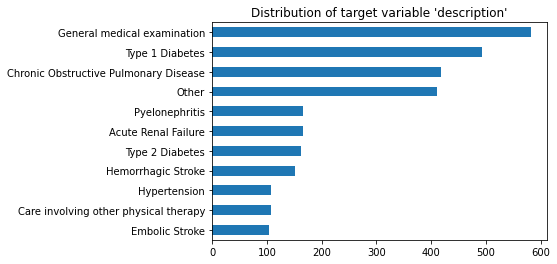

In [ ]:
# Plot the distribution in a graph
df_merged['description'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title("Distribution of target variable 'description'")
plt.show()

# Preprocess the data

We will now prepare the data to be used as the input and output values to train our machine learning model.

## Split into train and test sets

First, we will split the dataset into two separate training and test sets.  The examples in the training set will be used to develop the model, and the examples in the test set will be used to evaluate the model's performance on unseen data (data that was not used as part of the training process).

*Useful tip*: In this case study, we are using 75% of the records in the training set and 25% in the test set, but the train/test ratio can also be split 70/30 or 80/20 depending on the use case.  In general, you want to make sure that you have enough training examples to build a robust model, while partitioning off enough test examples to be used for calculating the final model performance.

In [ ]:
from sklearn.model_selection import train_test_split

# Define the input and output columns
# "X" is often used to denote the input/features
# "y" is often used to denote the output/target/label
X = df_merged['SOAP_Note_transformed']
y = df_merged['description']

# Split the records in the dataset randomly into train (75%) and test sets (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Number of examples in training set:", len(X_train))
print(f"Number of examples in test set:", len(X_test))

Number of examples in training set: 2151
Number of examples in test set: 717


We want to make sure that the distribution of output labels are similar within the training and test sets, so let's calculate the percentage of examples in each category within the train set (blue) and test set (orange) and compare them on a bar plot.

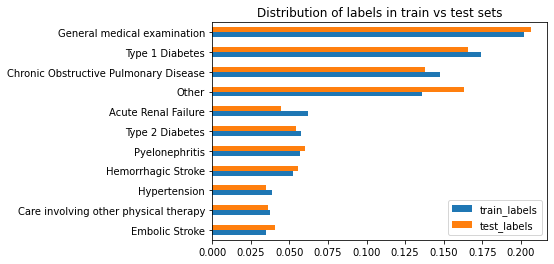

In [ ]:
# Plot the distribution of train and test labels
train_labels = y_train.value_counts(normalize=True).sort_values(ascending=True).rename('train_labels')
test_labels = y_test.value_counts(normalize=True).sort_values(ascending=True).rename('test_labels')

# Concatenate the number of examples in the train and test labels
label_counts = pd.concat([train_labels, test_labels], axis=1)

# Plot the number of example in the train and test sets for each label category
label_counts.plot(kind="barh")
plt.title("Distribution of labels in train vs test sets")
plt.show()

The categories in the target variables are similarly-distributed within the training and test sets.

## Encode labels

The model training process expects the categorical output values to be in numerical format instead of text.  For example, instead of "Hypertension", the model is expecting the target to be class "2". Therefore, we will use the LabelEncoder class to encode each categorical value into a corresponding numerical value and save the new encodings in y_train_transformed and y_test_transformed.

In [ ]:
from sklearn import preprocessing

# Initialize a LabelEncoder object
le = preprocessing.LabelEncoder()

# The fit() function takes the unique values in a column and encodes each one into a numerical label
le.fit(df_merged['description'])

# The transform() function formats and returns the corresponding numerical label
y_train_transformed = le.transform(y_train)
y_test_transformed = le.transform(y_test)

# For example, let's take a look at the first three output variables and its corresponding label
print(y_train[0:3].values)
print(y_train_transformed[0:3])

['Hypertension' 'Chronic Obstructive Pulmonary Disease'
 'General medical examination']
[6 2 4]


*Useful tip*: The inverse_transform() function takes in a list of numerical labels and returns the corresponding text label, which we will need at the end to convert our predicted categories back into human-readable text.

In [ ]:
# Check that we can inverse transform the categorical values
list(le.inverse_transform([2, 4, 6]))

['Chronic Obstructive Pulmonary Disease',
 'General medical examination',
 'Hypertension']

## Tokenize text input

An important aspect of NLP is "Tokenization", in which the input text is split into smaller units of individual phrases, sentences, words or parts of words.  These units are called "tokens", which are then further vectorized (converted into a numerical representation) so that they can be fed into a machine learning model.    

*Useful tip*: Although there are many different machine learning algorithms, the current state-of-the-art algorithms for NLP are based on the Transformer architecture.  We will first install the dependencies needed to use the transformers package in Python, and then look at several examples of how text can be tokenized using built-in transformer methods.

In [ ]:
# Download and install the transformers package
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.7 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 6.5 MB 47.7 MB/s 
     |████████████████████████████████| 67 kB 1.7 MB/s 
     |████████████████████████████████| 895 kB 59.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


There are many publicly-available pretrained models based on the Transformer architecture.  "Pre-trained" means that the model has already been trained on a large corpus of text to learn the language structure and context of words within a document.  We will leverage one of these pretrained models and then fine-tune it during the training process to match our use case. You will often see these pretrained models referred to as "BERT", which stands for "Bidrectional Encoder Representation from Transformers". 

Let's import a few different pretrained BERT-based models to compare the output of the tokenization results.  The three BERT models we'll look at are:

- Bio_ClinicalBERT (trained using clinical data)
- SciBERT (trained using scientific data)
- BERT (trained using regular text)

In [ ]:
# Import transformers package and several pretrained BERT models for comparison
from transformers import AutoTokenizer, BertTokenizer

# Bio_ClinicalBERT
bcbert_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# SciBERT
scibert_tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Tokenization examples

In the previous step, we downloaded several different BERT-based models.  In this step, we will see how the tokenize() function in each of these pretrained models can be used to split the text in one of the SOAP notes into smaller units.

In [ ]:
# Extract sample text to be used for tokenization
text = df_merged['SOAP_Note_transformed'][0]
print("Text:", wrap(text, 100), "\n")

# Split the text into tokens, with Bio_ClinicalBERT, BERT and SciBERT.
bcbert_tokens = bcbert_tokenizer.tokenize(text)
scibert_tokens = scibert_tokenizer.tokenize(text)
bert_tokens = bert_tokenizer.tokenize(text)

# Pad out the shorter lists to be the same length for display purposes
while len(scibert_tokens) < len(bcbert_tokens):
    scibert_tokens.append("")
while len(bert_tokens) < len(bcbert_tokens):
    bert_tokens.append("")

# Label the columns
print('{:<12} {:<12} {:<12}'.format("BC_BERT", "SciBERT", "BERT"))
print('{:<12} {:<12} {:<12}'.format("-------", "-------", "----"))

# Display the tokens
for tup in zip(bcbert_tokens, scibert_tokens, bert_tokens):
    print('{:<12} {:<12} {:<12}'.format(tup[0], tup[1], tup[2]))

Text: s : a 33 year old female crystallographer presents with mild spells of vertigo , mild headaches
particularly at the back of the head and in the morning x 2 weeks . pt also reports chronic mild
occasional lightheadedness . o : height 160 cm , weight 53 . 8 kg , temperature 37 . 3 c , pulse 76
, systolicbp 146 , diastolicbp 93 , respiration 15 , heart = 2 / 6 systolic murmur at base of heart
, chest = clear to auscultation b / l , no rales or wheezing , extremities = no edema or clubbing ,
heart = normal s1 , s2 , rrr a : p : performed e / m level 2 ( established patient ) - completed ,
and prescribed hydrochlorothiazide - 50 mg po qd , and ordered cholesterol . 

BC_BERT      SciBERT      BERT        
-------      -------      ----        
s            s            s           
:            :            :           
a            a            a           
33           33           33          
year         year         year        
old          old          old         
female     

As you can see, the tokenizer is able to split the text not only into individual words and punctuations, but also into parts of words.  The reason why we might want to split up a single words into separate parts is so that the training process can focus on the root of each word, like "headache" instead of "headaches", or the "crystal" part of "crystallographer".  

Overall, the output of all three BERT models are similar, so we will use the standard BERT model for our training process.

### Function to encode all text

This function tokenizes and encodes an entire text corpus into the expected input format for a BERT-based model.  

Return: Three arrays consisting of the tokens, masks and segments processed from the text.

In [ ]:
# Tokenize and encode text
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []
    
  for text in texts:
    # Tokenize the text
    text = tokenizer.tokenize(text)
            
    # Preprocess the text sequences to denote the start and end of text sequences
    text = text[:max_len-2]
    input_sequence = ["[CLS]"] + text + ["[SEP]"]
    pad_len = max_len - len(input_sequence)
    
    # Convert tokens into numerical sequences
    # Masks are special "hidden" tokens that are used as part of the training process
    # Segments IDs are used to denote separate sentence embeddings
    tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * max_len
    
    # Accumulate the tokens, masks and segments in the text encoding process
    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)
    
  # Return three arrays consisting of the tokens, masks and segments processed from the text
  # These arrays will be the input to our BERT-based training model
  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Train model

We are now ready to start training our model!  First, we will define the model structure, format the input and output values to match what is expected in the BERT model, and then build and train the model to see how well it can predict the diagnosis category from a patient's medical notes.

*Useful tip*: To train this model, we are using a machine learning concept called "Transfer Learning".  This means that we are using the pretrained weights in the standard BERT model as a base to help understand the underlying language structure and then adding a small neural network at the end to perform the actual classification tasks specific to our use case.  

## Define model structure

This function defines the model structure with a BERT base model and a 2-layer neural net to perform the classification task, resulting in an output representing how likely the input text corresponds to each one of the eleven output classes.

*Useful tip*: In our example, we are using the open-source TensorFlow platform, created by the Google Brain team, to train a neural network.  Another popular option for training neural networks is PyTorch, which is also an open-source platform created at Facebook's AI Research lab.

In [ ]:
def build_model(bert_layer, max_len=512):
  
  # Define the expected structure of the inputs to the model
  input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

  # Define the BERT pretrained model as the base layer
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  # Add a 2-layer neural net to output the likelihood of the input matching each of the output labels
  clf_output = sequence_output[:, 0, :]
  net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(32, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  out = tf.keras.layers.Dense(11, activation='softmax')(net)

  # Return the model structure
  model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

  # Define hyperparameters to customize and optimize the model training process
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Process model inputs

Format the input and output values to match the BERT model.

- Transform the text input into encoded tokens
- Transform the output labels into a categorical matrix format



In [ ]:
# The max length is the maximum sequence length to be used for training.
# BERT can handle up to 512 words in a sequence, but due to resource constraints,
# we will restrict the maximum sequence length to 150 words.
max_len = 150

# Encode the input text
train_input = bert_encode(X_train.values, bcbert_tokenizer, max_len=max_len)
test_input = bert_encode(X_test.values, bcbert_tokenizer, max_len=max_len)

# Reformat the output labels
train_labels = tf.keras.utils.to_categorical(y_train_transformed, num_classes=11)
test_labels = tf.keras.utils.to_categorical(y_test_transformed, num_classes=11)

## Build model

Download the base BERT model from TensorFlow Hub and build the model.  In the summary below, you can see that this model expects three inputs in the InputLayer corresponding to the preprocessed token, mask and segment arrays, followed by a Keras Layer which is the output of the base BERT model.  This output is then passed into our custom-defined 2-layer neural net with a final output of eleven nodes corresponding to the eleven possible diagnosis categories.  The value in each of the output nodes represents the model's prediction on how likely the input text matches a specific diagnosis.

In [ ]:
import tensorflow_hub as hub

# Download the base BERT model from TensorFlow Hub
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

# Build and display the model structure
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 150, 768)]                'input_mask[0][0]',         

## Run model

We will now run the model using the model.fit() method.  Each iteration, or epoch, of the training process will look at all the training examples and adjust the internal weights in the neural network model to reduce the amount of error in the prediction.  We will do ten passes in this training example, but feel free to increase or decrease the number of epochs to see its effect on performance.

To track the improvement in performance, the training process will calculate the accuracy score using a validation set that is automatically generated from 20% of the input data.  

Finally, the training process will compare whether the validation accuracy score has improved from the previous iterations, and if so, the model parameters will be saved.  This is done because a model can potentially be "overtrained", in which case its performance will actually start decreasing, so we want to stop at the point where the model has the best performance and remember those parameters. 

*Note*: This section may take 5-10 minutes to run.

In [ ]:
# Train the model using BERT as the pretrained layer
num_epochs = 10
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=num_epochs,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 2.1977 - accuracy: 0.2372
Epoch 1: val_accuracy improved from -inf to 0.55220, saving model to model.h5
54/54 [==============================] - 56s 763ms/step - loss: 2.1977 - accuracy: 0.2372 - val_loss: 1.6942 - val_accuracy: 0.5522
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 1.6463 - accuracy: 0.5105
Epoch 2: val_accuracy improved from 0.55220 to 0.66589, saving model to model.h5
54/54 [==============================] - 40s 751ms/step - loss: 1.6463 - accuracy: 0.5105 - val_loss: 1.1502 - val_accuracy: 0.6659
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 1.2818 - accuracy: 0.6012
Epoch 3: val_accuracy improved from 0.66589 to 0.77262, saving model to model.h5
54/54 [==============================] - 40s 750ms/step - loss: 1.2818 - accuracy: 0.6012 - val_loss: 0.8967 - val_accuracy: 0.7726
Epoch 4/10
54/54 [==============================] - ETA: 0s - loss: 1.0449 - accur

## Graph training progress

Visualize the training process by plotting progressive decrease in loss and increase in accuracy over the number of epochs, for both the training and validation sets.

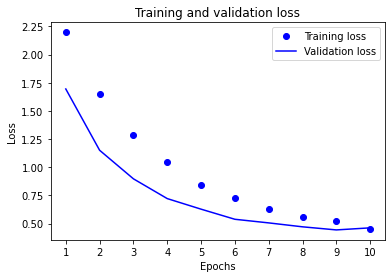

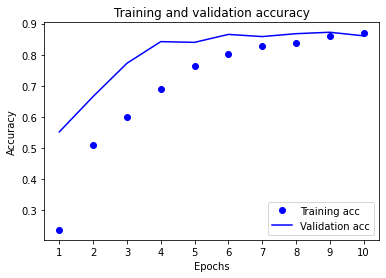

In [ ]:
# Define a function to display graphs comparing the train and validation loss and accuracy
def showGraphs(history):

  # Extract the accuracy and loss values from the history object
  history_dict = history.history
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Define the number of epochs to be used in the plot
  epochs = range(1, len(acc) + 1)

  # Construct and show the graph comparing the change in loss between 
  # the training and validation sets over epochs
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.xticks(range(1,num_epochs+1,1))
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.clf()   # clear figure
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']

  # Construct and show the graph comparing the change in accuracy between
  # the training and validation sets over epochs
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.xticks(range(1,num_epochs+1,1))
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# Compare train and validation loss and accuracy over epochs
showGraphs(train_history)

# Evaluate model

Congratulations, you've succesfully trained a machine learning model that can be used to predict a patient's diagnosis from SOAP notes!  Now we have to evaluate the performance of the model on the test set.  Remember that this test set was partitioned out from the entire dataset so the examples in this test set have not been used in the training process.

## Accuracy score on test set

To calculate the model performance on the test set, we will pass the input text examples from the test set into the model and ask it to predict the diagnosis class for each input.  Out of the eleven possible classes, the actual predicted value will be the class that has the highest likelihood based on the predicted values.  This set of predicted values (y_pred) will then be compared to the actual labels in the test set (y_true) to calculate the overall accuracy score.

In [ ]:
from sklearn.metrics import accuracy_score

# Load the parameters from the last saved model
model.load_weights('model.h5')

# Make a prediction on each of the inputs in the test set
predictions = model.predict(test_input)

# Define a y_pred array containing the model's "best prediction" for each given input
y_pred = np.argmax(predictions, axis=1)

# Define a y_true array containing the actual labels for each input in the test set
y_true = y_test_transformed

# Calculate accuracy score on the test set by comparing the true vs predicted values
test_acc = accuracy_score(y_true, y_pred)
print(f"Accuracy score on the test set is: {round(test_acc, 3)}")

Accuracy score on the test set is: 0.862


## Compare accuracy between train and test sets

In order to determine whether the model is generalizable to unseen data, we will compare the validation accuracy (the accuracy achieved on the training set) and the test accuracy (the accuracy on the test set, which was not used during the process).  Ideally, the accuracy score on the test set should be similar to that of the training set, indicating that the model is consistently able to make predictions at the same accuracy level even on previously unseen data.

In [ ]:
# Retrieve the last value for the validation accuracy score on the training set
val_acc = train_history.history['val_accuracy'][-1]
print(f"Accuracy score on the training set is: {round(val_acc, 3)}")

Accuracy score on the training set is: 0.861


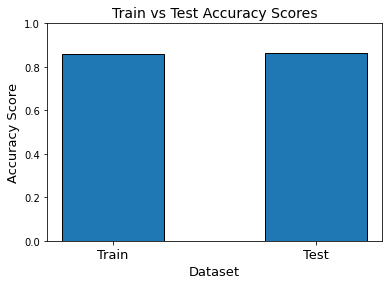

In [ ]:
# Plot train vs test accuracy scores
plt.title("Train vs Test Accuracy Scores", fontsize=14)

# Set up the data to be compared
dataset = ['Train', 'Test']
acc_score = [val_acc, test_acc]

# Plot the comparison graphs
plt.bar(dataset, acc_score, width=0.50, edgecolor='k')
plt.ylim(0,1)
plt.xticks(fontsize=13)
plt.xlabel("Dataset", fontsize=13)
plt.ylabel("Accuracy Score", fontsize=13)
plt.show()


## Confusion Matrix

A confusion matrix is a great way to visualize the results of a classification model.  For each entry in the test set, the x-axis shows the predicted diagnosis and the y-axis shows the actual diagnosis.

In the example below, we see that the predicted and actual categories are mostly aligned.  The category that is most often incorrectly predicted is "Other", which is not surprising as this is a general category containing many different examples of diagnoses.

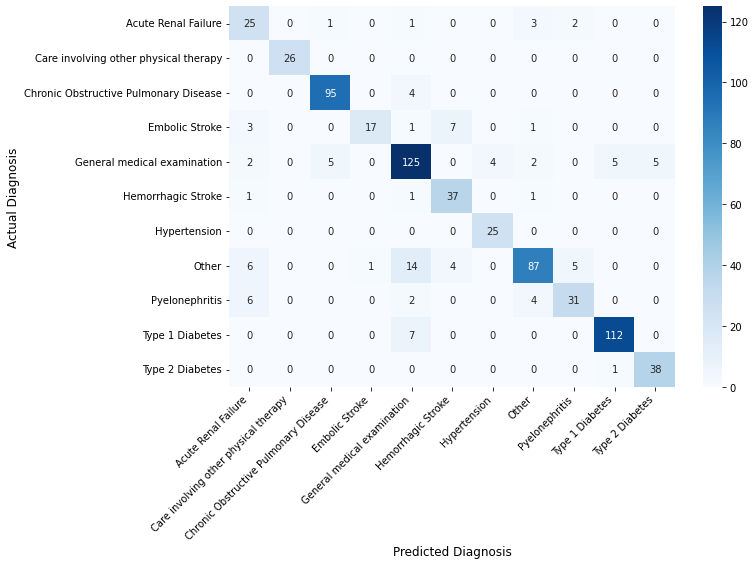

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix based on predictions vs actual labels
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with labels
plt.figure(figsize = (10,7))
labels = le.inverse_transform(range(0,11))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Diagnosis", fontsize=12)
plt.ylabel("Actual Diagnosis", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

## Precision, Recall and F1-score

Performance metrics used for classification models also include Precision, Recall and F1-score.

**Precision**: 
- *How many of what the model predicted as positive are actually positive?*
- Formula for Precision: True Positive / (True Positive + False Positive)

**Recall:** 
- *How many of actual positives are truly predicted by the model?*
- Formula for Recall: True Positive / (True Positive + False Negative)

**F1-score**: 
- *A weighted average of precision and recall scores*
- Formula for F1-score: 2 x (Precision * Recall) / (Precision + Recall)

In [ ]:
from sklearn.metrics import classification_report

# The classification_report method will print out the precision, recall and f1-scores for each class
# Alternatively, the sklearn.metrics package also includes methods to calculate many other types of metrics
print(classification_report(y_true, y_pred, target_names=labels))

                                       precision    recall  f1-score   support

                  Acute Renal Failure       0.58      0.78      0.67        32
Care involving other physical therapy       1.00      1.00      1.00        26
Chronic Obstructive Pulmonary Disease       0.94      0.96      0.95        99
                       Embolic Stroke       0.94      0.59      0.72        29
          General medical examination       0.81      0.84      0.83       148
                   Hemorrhagic Stroke       0.77      0.93      0.84        40
                         Hypertension       0.86      1.00      0.93        25
                                Other       0.89      0.74      0.81       117
                       Pyelonephritis       0.82      0.72      0.77        43
                      Type 1 Diabetes       0.95      0.94      0.95       119
                      Type 2 Diabetes       0.88      0.97      0.93        39

                             accuracy             

## Test prediction examples

Finally, let's look at different examples of SOAP notes, its corresponding diagnosis prediction based on our trained model, and what the diagnosis actually is.  Feel free to run the code snippet below as many times as you like -- each time the code will choose a random example from the test set.

In [ ]:
import random

# Pick a random test record
test_id = random.randint(0, len(y_test))
print("Test record ID:", test_id, "\n")

# Print the soap note, predicted diagnosis, and actual diagnosis
print("SOAP note (diagnosis removed):\n", wrap(X_test.values[test_id], 100), '\n')
print("Predicted diagnosis:", le.inverse_transform([y_pred[test_id]])[0])
print("Actual diagnosis:", y_test.values[test_id])

Test record ID: 470 

SOAP note (diagnosis removed):
 s : 18 yo f with 2 weeks old amputated lt presents for physical therapy visit . pt reports no issues
o :, extremity = no redness , no pus , good strength ; treatment provided : mobility and gait
training a : p : continue as per plan with sessions every three days . performed rehabilitation and
remedial exercises following of - - patient tolerated treatment well and appears to be compliant
with home exercise program . 

Predicted diagnosis: Other
Actual diagnosis: Other


Congratulations, you have completed an optional Python tutorial in the ‘AI for Clinician Champions Certificate' program! 

https://michener.ca/ce_course/ai-for-clinician-champions-certificate-program/




This program is offered by Michener Institute & Vector Institute for clinicians who wish to learn more about AI in Healthcare.

***Never stop learning!***